<a href="https://colab.research.google.com/github/IzanagiRoot/Python-Linear-Regression/blob/master/Gender_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import pandas as pd
import numpy as np
from io import BytesIO
from zipfile import ZipFile
import requests
import scipy
import matplotlib.pyplot as plt
from scipy import signal
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from skimage.feature import hog
from skimage.color import rgb2grey

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.exceptions import UndefinedMetricWarning

import warnings

In [0]:
url = "https://github.com/IzanagiRoot/Python-Linear-Regression/raw/master/faces94.zip"

# Extract Zip file and store content in datasets folder
content = requests.get(url)
zf = ZipFile(BytesIO(content.content))
zf.extractall("datasets_V2")
labels = pd.read_csv(zf.open("faces94/labels.csv"))
zf.close()

In [0]:
def get_image(row_id, root="datasets_V2/faces94/"):
  
  filename = "{}.jpg".format(row_id)
  file_path = os.path.join(root, filename)
  #img = Image.open(file_path)
  dim = (64,64)
  img = cv2.imread(file_path,0)
  resized_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  return dct2(resized_img)

In [0]:
def dct2(a):
    return scipy.fftpack.dct( a, type=2,norm='ortho' )

In [0]:
def create_features(img):
    # convert image to greyscale
    grey_image = rgb2grey(img)
    # get HOG features from greyscale image
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    flat_features = np.hstack(hog_features)
    return flat_features

In [0]:
def create_feature_matrix(label_dataframe):
    features_list = []
    for img_id in label_dataframe.Name:
        # load image
        img = get_image(img_id)
        # get features for image
        image_features = create_features(img)
        features_list.append(image_features)
    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix

# run create_feature_matrix on our dataframe of images
feature_matrix = create_feature_matrix(labels)

In [7]:
print(__doc__)

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(feature_matrix)
X = feature_matrix.reshape((n_samples, -1))
y = labels.Class.values

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            clf = GridSearchCV(
                SVC(), tuned_parameters,cv=5, scoring='%s_macro' % score
            )
            clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 10, 'kernel': 'linear'}

Grid scores on development set:

0.436 (+/-0.001) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.436 (+/-0.001) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.436 (+/-0.001) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.436 (+/-0.001) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.436 (+/-0.001) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.436 (+/-0.001) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.968 (+/-0.013) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.436 (+/-0.001) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.946 (+/-0.006) for {'C': 1, 'kernel': 'linear'}
0.978 (+/-0.005) for {'C': 10, 'kernel': 'linear'}
0.962 (+/-0.039) for {'C': 100, 'kernel': 'linear'}
0.951 (+/-0.058) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on

In [8]:
X = pd.DataFrame(feature_matrix)
y = pd.Series(labels.Class.values)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.3,
                                                    random_state=1234123)
# define support vector classifier
model = SVC(kernel='linear', C = 10, probability= True)
#clf = SVC(kernel='rbf',C = 1000, gamma=0.001)
# fit model
model.fit(X_train, y_train)

# calculate 5-Cross-Validation
#scores = cross_val_score(clf, X, y, cv=2)
#print("Accuracy 5-Cross-Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#Predict the response for test dataset
y_pred = model.predict(X_test)
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9738562091503268
Precision: 0.9652173913043478
Recall: 0.8473282442748091


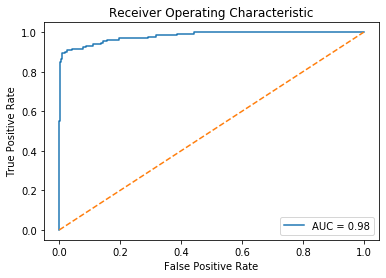

In [9]:
# predict probabilities for X_test using predict_proba
probabilities = model.predict_proba(X_test)

# select the probabilities for label 1.0
y_proba = probabilities[:, 1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_proba, pos_label=1)

# calculate AUC
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')  ;

In [0]:
# Let's export model
import pickle
pickle.dump(model, open('gender_model.pkl', 'wb'))
from google.colab import files

In [0]:
files.download('gender_model.pkl')